# Finding a Competent Subset for Visualization, Simulation, or 3D Printing

This notebook contains functions and the workflow for finding a competent subset for visualization.

**Author Contact:** <br>
LinkedIn: [Çınar Turhan](https://www.linkedin.com/in/cinarturhan/) <br>
Email: [cinarturhan@utexas.edu](mailto:cinarturhan@utexas.edu)

## Finding a Competent Subset <a class="anchor" id="chapter1"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import pyvista as pv
pv.set_jupyter_backend('html')
pv.start_xvfb()

import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy
import glob
import scipy
import os
from pathlib import Path
import sys

sys.path.append('../')

from dpm_tools.io import read_image, Image
from dpm_tools.visualization import plot_isosurface, extract_competent_subset, plot_medial_axis

[01:38:59] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=513538;file:///home/gomathecat/myvenvs/dpm_tools_venv/lib64/python3.11/site-packages/openpnm/utils/_workspace.py\_workspace.py]8;;\:]8;id=731935;file:///home/gomathecat/myvenvs/dpm_tools_venv/lib64/python3.11/site-packages/openpnm/utils/_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

<!-- ## Functions <a class="anchor" id="section_1_2"></a> -->

## Function: `extract_competent_subset`

This function identifies the best cubic subset for visualizing a segmented dataset.

### Parameters:
- **data**: A 3D numpy array, or an instance of `Vector` or `Image` class from DPM Tools.
- **cube_size**: The size of the visualization cube. Default is 100 (100x100x100).
- **batch**: The batch size over which to calculate the statistics. Default is 100.
- **pore_class**: The class representing pores in the dataset. Default is 0.

### Description:
The function processes the input `data` to find a cubic subset that best represents the porosity of the segmented dataset. It performs the following steps:

1. **Data Preparation**:
   - If `data` is an instance of `Vector` or `Image` from DPM Tools, it extracts the scalar data.
   - Adjusts the scalar data based on the `pore_class`.

2. **Porosity Calculation**:
   - Computes the overall porosity of the dataset.

3. **Subset Selection**:
   - Defines the size of the sample cube and the increment for the inner cube.
   - Calculates the maximum possible batch number and initializes a statistics array.

4. **Batch Processing**:
   - Iterates through possible batches to find the best subset:
     - Randomly selects a cubic subset and its inner cube.
     - Uses connected component analysis to find the largest connected components outside and inside the inner cube.
     - Calculates the porosity of the selected subset.
     - Stores the statistics if the subset's porosity is within a specified range.

5. **Best Subset Identification**:
   - Identifies the best subset based on the harmonic mean of the outside and inside component counts.
   - Prints the original and subset porosity, and the range of the competent subset.

### Returns:
- **best_subset_range**: A tuple representing the range of the best subset.
- **stats_array**: An array containing the statistics of the processed batches.

### Example Usage:
```python
best_subset_range, stats_array = find_porosity_visualization_subset(data, cube_size=100, batch=100, pore_class=0)

In [2]:
def plot_sample(sample, subset=True, subset_range = (0,128)):
  
    plotter_obj = pv.Plotter(lighting='three lights')

    # Set background colors
    plotter_obj.set_background(color='w')

    # Set font colors and sizes
    pv.global_theme.font.color = 'black'
    pv.global_theme.font.size = 18
    pv.global_theme.font.label_size = 14
    
    pv.set_jupyter_backend('html')
    
    mini = subset_range[0]
    maxi = subset_range[1]

    if subset:
        sample = sample[mini:maxi,mini:maxi,mini:maxi]

    sample = np.pad(sample, ((1, 1), (1, 1), (1, 1)), mode='constant', constant_values=1)
    sample = Image(scalar=sample)
    
    plotter_obj = plot_isosurface(sample, plotter_obj, show_isosurface=[0.5], 
                    mesh_kwargs={"opacity":1, 
                                "color":(200 / 255, 181 / 255, 152 / 255), 
                                "diffuse": 0.75, 
                                "ambient": 0.15})
    
    
    plotter_obj.show(jupyter_backend='html')

## Loading the Data <a class="anchor" id="section_1_3"></a>

In these datasets, pores are set to 1, and the solids are set to 0.

In [ ]:
img_list = Path('../data/').glob('*.tif')
beadpack, _, gambier = [read_image(tif_img) for tif_img in sorted(img_list)]

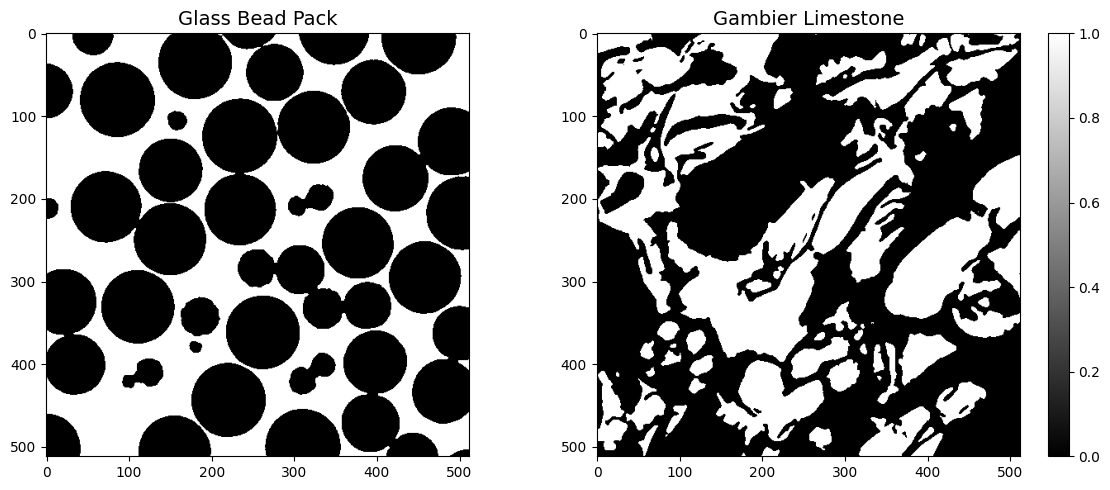

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = ax.flatten()

im = ax[0].imshow(beadpack[0,:,:], cmap='gray', interpolation=None)
ax[0].set_title('Glass Bead Pack',fontsize=14)

im2 = ax[1].imshow(gambier[0,:,:], cmap='gray', interpolation=None)
ax[1].set_title('Gambier Limestone',fontsize=14)

plt.colorbar(im2)
plt.tight_layout()
plt.show()

## Initial Visualizations <a class="anchor" id="section_1_4"></a>

In [6]:
subset_range = (128,256)
plot_sample(beadpack, subset=True, subset_range=subset_range)
plot_sample(gambier, subset=True, subset_range=subset_range)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [18]:
# Porosity of the selected subset of Gambier Limestone
gambier_128 = gambier[128:256, 128:256, 128:256]
porosity = np.sum(gambier_128 == 1)/(128**3)*100
print(round(porosity, 1), '%')

71.6 %


## Finding the Competent Subsets <a class="anchor" id="section_1_4"></a>

In [21]:
subset1, _ = extract_competent_subset(beadpack, cube_size=128, batch=100, pore_class = 1)

Original Porosity: 37.88 %
Subset Porosity: 37.89 %
Competent Subset: [183:311,            183:311, 183:311]


In [22]:
subset2, _ = extract_competent_subset(gambier, cube_size=128, batch=100, pore_class = 1)

Original Porosity: 43.59 %
Subset Porosity: 50.36 %
Competent Subset: [224:352,            224:352, 224:352]


## Final Visualizations <a class="anchor" id="section_1_5"></a>

In [ ]:
plot_sample(beadpack, subset=True, subset_range=subset1)
plot_sample(gambier, subset=True, subset_range=subset2)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Obtaining the Medial Axis <a class="anchor" id="chapter2"></a>

In [ ]:
plot_medial_axis(beadpack[165:293,165:293,165:293], pore_class=1, interactive=False)
plot_medial_axis(gambier[62:190,62:190,62:190], pore_class=1, interactive=False)

Widget(value='<iframe src="http://localhost:42157/index.html?ui=P_0x7f5ccb0e2f50_3&reconnect=auto" class="pyvi…

____

Author: [Çınar Turhan](https://www.linkedin.com/in/cinarturhan/)